# Modello convolutivo di base
Lo scopo di questo notebook è creare un **modello convolutivo di base** con un'architettura semplice. In seguito, sarà interessante confrontare i risultati di questo primo modello con i risultati ottenuti da modelli più complessi, o pre addestrati.

Come al solito, si procede con l'importazione delle librerie utilizzate e la creazione dei set di allenamento e validazione.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os

In [2]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split (se no darebbe errore)
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split (se no darebbe errore)
)

label_names = train_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.


In [3]:
for audios, labels in train_ds:
    print("Forma (shape) audio:", audios.shape)
    print("Forma (shape) classi:", labels.shape)
    break

Forma (shape) audio: (32, 16000, 1)
Forma (shape) classi: (32,)


Lo shape dell'audio è di (32, 16000, 1), indicando che ogni file è contenuto in un batch di 32 tensori unidimensionali di lunghezza 16000. Inoltre, lo shape delle classi è anch'esso 32. Questo perché la funzione `tf.keras.utils.audio_dataset_from_directory(directory)` ha il parametro `batch_size` impostato a 32 di default, non avendolo specificato la dimensione è rimasta tale.

## Funzioni per processamento dei dati

Il prossimo step è definire la funzione `squeeze(audio, labels)`, la quale prende come argomenti l'audio e le classi.

Questa funzione serve per rimuovere l'ultimo asse dello shape dai nostri audio. Attualmente, lo shape dei dati è (32, 16000, 1), ma si può eliminare l'ultima dimensione poiché non necessaria. Specificando il parametro **axis=-1** nella funzione `tf.squeeze` la forma dell'audio viene trasformata in (32, 16000).

Eseguiamo questa semplificazione sulla forma del dato poiché rende la fase di processamento dei dati più efficiente.

In [4]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [5]:
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
validation_ds = validation_ds.map(squeeze, tf.data.AUTOTUNE)

audio, label = next(iter(train_ds))
print(audio.shape)
print(label.shape)

(32, 16000)
(32,)


Una volta eseguito questa semplificazione, a partire dai tensori degli audio, creeremo gli spettrogrammi che sarannò presi come input dal modello convolutivo.

## Conversione e suddivisione dataset
Andremo ad utilizzare due funzioni: `get_spectrogram` e `get_spectrogram_dataset`. Queste due funzioni usate insieme convertono il nostro dataset di audio in un dataset di spettrogrammi. La prima funzione `get_spectrogram` converte il singolo audio in spettrogramma mentre la seconda funzione `get_spectrogram_dataset` richiama la prima funzione per ogni dato presente nel dataset.

In [6]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)

    return spectrogram[..., tf.newaxis]

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

In [7]:
def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

# fonte: funzione presa dal seguente link: https://www.geeksforgeeks.org/audio-recognition-in-tensorflow/

Definite le due funzioni possiamo procedere a ottenere il nostro **training set**, **validation set**, e **test set** di spettrogrammi. La suddivisione di dati ricordo essere rispettivamente 60%, 20%, 20%.

In [8]:
train_ds = get_spectrogram_dataset(train_ds)
validation_ds = get_spectrogram_dataset(validation_ds)

val_ds = validation_ds.take(validation_ds.cardinality() // 2) # ho cambiato nome del validation_ds in modo tale da non creare problemi con l'istruzione seguente
test_ds = validation_ds.skip(validation_ds.cardinality() // 2)

In [9]:
print("Numero di audio training set:", len(train_ds) * 32)
print("Numero di audio validation set:", len(val_ds) * 32)
print("Numero di audio test set:", len(test_ds) * 32)

Numero di audio training set: 7776
Numero di audio validation set: 2592
Numero di audio test set: 2592


Shape (forma) spettrogrammi: (32, 124, 129, 1)


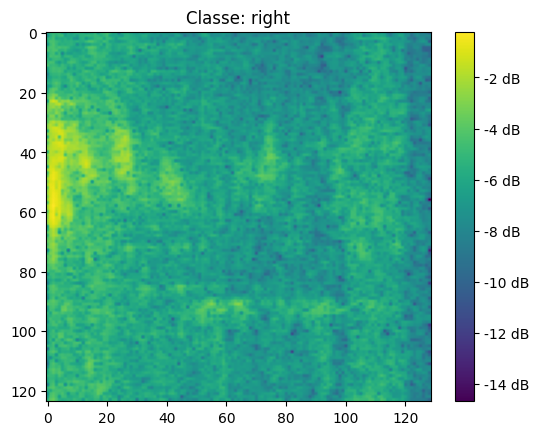

In [10]:
for audio, label in train_ds:
    print("Shape (forma) spettrogrammi:", audio.shape)

    spectrogram = np.squeeze(audio[0])
    spectrogram = np.log(spectrogram.T)

    plt.imshow(spectrogram.T)
    plt.colorbar(format='%+2.0f dB') # barra laterale dei dB

    plt.title(f"Classe: {label_names[label[0].numpy()]}")
    break

La grandezza degli spettrogrammi, quindi delle immagini ottenute, è di **124x129**.

## Creazione modello di base

Come modello implementiamo una rete neurale convolutiva. Questo modello ha un'architettura semplice e servirà da benchmark per i modelli futuri.

La rete prende in ingresso tensori di forma **altezza x larghezza x canali**, rispettivamente di **124, 129, 1**. Per farlo lavorare meglio, rendiamo le immagini di dimensione quadrata e normalizziamo i dati con la funzione `tf.keras.layers.Normalization()`.

L'architettura del modello è suddivisa in **due blocchi** principali: un blocco per l'apprendimento delle caratteristiche e un blocco per la classificazione.

Il **blocco di apprendimento delle caratteristiche** ha un'architettura formata da una serie di livelli convolutivi alternati a livelli di max pooling. Per ciascun livello convolutivo viene anche applicata la funzione di attivazione **ReLu** per applicare non linearità. Il blocco termina con un livello convolutivo di **256 filtri**, che corrispondono alla stessa quantità di filtri applicati dal livello convolutivo precedente.

Terminato il blocco di apprendimento delle caratteristiche, è presente il **blocco di classificazione**, formato da un **livello di Flatten**, necessario per trasformare i dati in un vettore unidimensionali, e un **livello Dense**, necessario per la predizione della classe di appartenenza del dato. Quest'ultimo livello Dense ha **30 unità**, che corrispondono alle 30 classi del nostro task di classificazione multiclasse. La funzione di attivazione applicata dal livello Dense è la **softmax**, ideale per i task di classificazione multiclasse. 

La funzione **softmax**, a differenza della funzione **sigmoid** ci fornisce una distribuzione di probabilità sulle classi possibili (questa distribuzione saremo in grado di visualizzarla durante la valutazione del modello).

In [11]:
def get_basic_model():
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = tf.keras.layers.Resizing(120, 120)(inputs)
    x = tf.keras.layers.Normalization()(x)

    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

Nella prossima cella di codice dichiariamo l'**ottimizzatore** da utilizzare (rmsprop), le **metriche** di cui tenere traccia (accuratezza), e la funzione di perdita da utilizzare per il calcolo del gradiente. Nel nostro caso la **funzione di perdita** corrisponde alla `sparse_categorical_crossentropy`, una variante della `categorical_crossentropy`.

La **sparse categorical crossentropy** viene utilizzata quando le classi sono rappresentate come interi, proprio come nel nostro caso.

In [12]:
basic_model = get_basic_model() 
basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

basic_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 124, 129, 1)]     0         
                                                                 
 resizing (Resizing)         (None, 120, 120, 1)       0         
                                                                 
 normalization (Normalizatio  (None, 120, 120, 1)      3         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 118, 118, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 57, 57, 64)        18496 

Il modello ha un totale di circa **1 milione di parametri**, bilanciando complessità e capacità di apprendimento.

In [13]:
basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/basic_model.keras", save_best_only=True, monitor="val_loss")]
basic_model_history = basic_model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=basic_model_callbacks)

Epoch 1/30
243/243 [==============================] - 8s 16ms/step - loss: 2.6921 - accuracy: 0.2387 - val_loss: 1.9536 - val_accuracy: 0.4298
Epoch 2/30
243/243 [==============================] - 3s 12ms/step - loss: 1.4477 - accuracy: 0.5885 - val_loss: 1.2257 - val_accuracy: 0.6481
Epoch 3/30
243/243 [==============================] - 3s 11ms/step - loss: 0.8431 - accuracy: 0.7570 - val_loss: 0.9175 - val_accuracy: 0.7450
Epoch 4/30
243/243 [==============================] - 3s 10ms/step - loss: 0.5711 - accuracy: 0.8366 - val_loss: 0.9937 - val_accuracy: 0.7755
Epoch 5/30
243/243 [==============================] - 3s 12ms/step - loss: 0.4120 - accuracy: 0.8763 - val_loss: 0.6612 - val_accuracy: 0.8256
Epoch 6/30
243/243 [==============================] - 3s 12ms/step - loss: 0.3173 - accuracy: 0.9050 - val_loss: 1.0387 - val_accuracy: 0.7921
Epoch 7/30
243/243 [==============================] - 3s 12ms/step - loss: 0.2382 - accuracy: 0.9304 - val_loss: 0.7268 - val_accuracy: 0.8453

Alleniamo il modello per 30 epoche e visualizziamo le **curve di addestramento** e **validazione**.

In [14]:
def create_train_val_plot(history, overfit=True):
    # definisco numero epoche
    epochs = range(1, len(history['accuracy']) + 1)
    
    # Accuracy
    accuracy = history['accuracy']
    val_accuracy = history['val_accuracy']

    fig_acc, ax_acc = plt.subplots()
    
    # linea di base
    ax_acc.plot(epochs, [0.5 for x in range(len(epochs))], color="lightgray", linestyle="--", label="Base")
    # linee di accuratezza
    ax_acc.plot(epochs, accuracy, color="slategray", label="Accuratezza in addestramento")
    ax_acc.plot(epochs, val_accuracy, color="indianred", label="Accuratezza in validazione")
    # miglior accuratezza validazione
    ax_acc.axhline(y=max(val_accuracy), c='indianred', alpha=0.7, linestyle='--')
    ax_acc.text(len(epochs) * 1.07, max(val_accuracy), round(max(val_accuracy), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_acc.spines["right"].set_visible(False)
    ax_acc.spines["top"].set_visible(False)
    ax_acc.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_acc.set_title("Accuratezza in addestramento e validazione")
    ax_acc.set_xlabel("Epoche")
    ax_acc.set_ylabel("Accuratezza (%)")
    ax_acc.legend()

    # Loss
    loss = history['loss']
    val_loss = history['val_loss']
    
    fig_loss, ax_loss = plt.subplots()

    # linee di loss
    ax_loss.plot(epochs, loss, color="slategray", label="Perdita in addestramento")
    ax_loss.plot(epochs, val_loss, color="indianred", label="Perdita in validazione")
    # miglior loss validazione
    ax_loss.axhline(y=min(val_loss), c='indianred', alpha=0.7, linestyle='--')
    ax_loss.text(len(epochs) * 1.07, min(val_loss), round(min(val_loss), 2), fontsize=9, fontweight="bold", horizontalalignment="left", verticalalignment="center")
    # nascondo limiti plot
    ax_loss.spines["right"].set_visible(False)
    ax_loss.spines["top"].set_visible(False)
    ax_loss.spines["left"].set_visible(False)
    # definizione label e titolo + legenda
    ax_loss.set_title("Perdita in addestramento e validazione")
    ax_loss.set_xlabel("Epoche")
    ax_loss.set_ylabel("Perdita")

    handles, _ = ax_loss.get_legend_handles_labels()
    
    if overfit:
        # area overfit
        rect = mpatches.Rectangle((np.argmin(val_loss) + 1, 0), width=100 - np.argmin(val_loss), height=max(max(loss), max(val_loss)), color='lightcoral', alpha=0.3)
        ax_loss.add_patch(rect)
        # patch overfit per legenda
        overfit = mpatches.Patch(color='indianred', alpha=0.3, label='Area overfit')
        handles, _ = ax_loss.get_legend_handles_labels()
        handles.append(overfit)
        
    # legenda
    ax_loss.legend(handles=handles)
    
    plt.show()

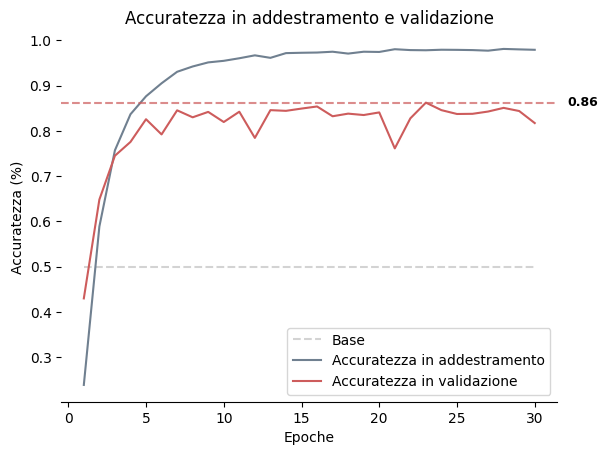

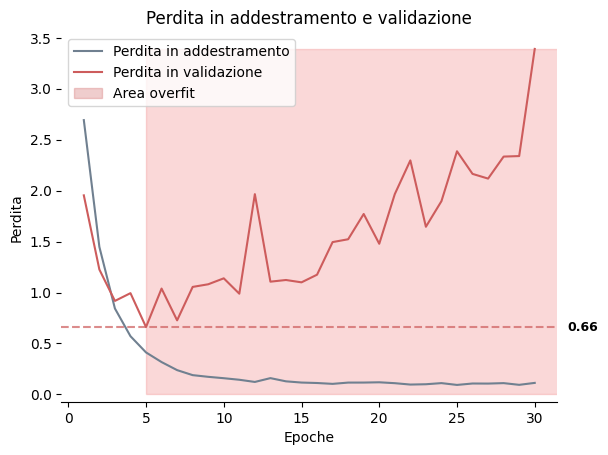

In [15]:
create_train_val_plot(basic_model_history.history)

Questi grafici mostrano come il nostro modello sia andato immediatamente in overfitting. L'accuratezza dell'addestramento aumenta col tempo e raggiunge quasi il **100%**, mentre l'accuratezza della validazione si attesta sull'**80%** con un **picco del 86%**. Inoltre, la **perdita nel set di addestramento** continua a diminuire mentre la **perdita nel set di validazione** aumenta.

Possiamo verificare l'accuratezza della migliore versione del nostro modello di base ricaricando il file **basic_model.keras**.

In [16]:
best_basic_model = tf.keras.models.load_model("bestmodels/basic_model.keras")
test_loss, test_acc = best_basic_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 3s 8ms/step - loss: 0.7196 - accuracy: 0.8198
Accuratezza: 0.820


Abbiamo ottenuto un'**accuratezza** del **82%**! La complessità di questo task è legata fortemente alla **quantità di classi** e alla **dimensione limitata del dataset**. Considerato ciò, il risultato ottenuto non è male.

Infine, creiamo una funzione utile a visualizzare graficamente la distribuzione di accuratezza delle classi su un'immagine casuale, per capire come ha lavorato il modello. Nel caso il modello non predica correttamente, la **classe corretta** verrà sempre evidenziata di **verde** mentre la **classe predetta** verrà evidenziata di **giallo**.

In [17]:
def create_distribution_plot(model, audio, label):
    prediction = model(audio) # otteniamo la predizione del modello sull'audio preso in input
    softmax_pred = tf.nn.softmax(prediction[0]) # dobbiamo applicare nuovamente la softmax in modo tale da avere dei dati leggibili
    pred_label = np.argmax(softmax_pred) # ci salviamo l'indice della label predetta dal nostro modello, quella con la probabilità più alta

    colors = ['indianred'] * len(label_names) # creiamo un vettore di lunghezza 30 (la quantità delle nostre label) colorate di rosso

    if pred_label == label[0].numpy(): # se la label che abbiamo predetto è corretta, allora la coloriamo di verde
        colors[pred_label] = 'seagreen'
    else: # se la label che abbiamo predetto è sbagliata, allora coloriamo di verde la corretta e di gialla la predetta
        colors[pred_label] = 'khaki'
        colors[label[0].numpy()] = 'seagreen'

    plt.figure(figsize=(12, 4))

    plt.bar(label_names, softmax_pred.numpy(), color=colors)
    plt.xticks(rotation=45)

    # dichiariamo i colori della legenda
    other_values_patch = mpatches.Patch(color='indianred', label='Altre classi')
    pred_value_patch = mpatches.Patch(color='khaki', label='Classe predetta')
    correct_value_patch = mpatches.Patch(color='green', label='Classe corretta')

    # disegniamo al legenda con i colori necessari
    if pred_label == label[0].numpy(): # se abbiamo predetto correttamente la label, non è necessario mostrare il colore giallo (non è presente nel plot)
        plt.legend(handles=[other_values_patch, correct_value_patch])
    else:
        plt.legend(handles=[other_values_patch, pred_value_patch, correct_value_patch])

    plt.show()

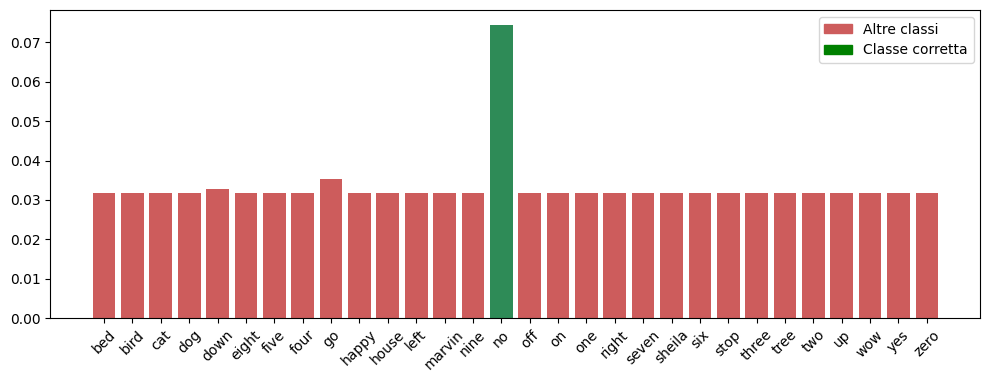

In [18]:
for audio, label in test_ds: # prendiamo un audio a caso del test e creiamo la distribuzione
    create_distribution_plot(best_basic_model, audio, label)
    break

Possiamo notare dalla distribuzione che il modello in questo caso ha predetto correttamente la **classe no**. Inoltre possiamo notare che la **classe go** ha qualche punto percentuale in più delle altre, il che ha senso essendo una parola molto simile (ergo uno spettrogramma simile).

L'overfitting è probabilmente fortemente causato dal fatto che il nostro dataset contiene un numero insufficente di campioni, rendendolo non in grado di generalizzare su dati nuovi. Per migliorare la capacità di generalizzare del modello andremo a creare dei dati artificali con le tecniche di data agumentation.

### Risoluzione dell'overfitting
Abbiamo capito che il modello è andato immediatamente in **overfitting**, e lo possiamo notare dalla loss di validazione che inizia a salire dalla quinta epoca in poi. L'obbiettivo principale in questo momento è evitare che vada in overfitting troppo velocemente, applicando le tecniche viste a lezione.

Utilizzeremo la tecnica della **data augmentation** per risolvere la grandezza ridotta del dataset, e inoltre applicheremo un **livello di Dropout** al **blocco di classificazione**.

In [19]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1)
    # tf.keras.layers.RandomZoom(0.2) # -> non ci stava dando risultati e aumentava il tempo di training
    # tf.keras.layers.RandomTranslation(height_factor=5/124, width_factor=0)
    # tf.keras.layers.RandomTranslation(height_factor=0, width_factor=5/129)
    # questi ultimi due layer non ci stavano dando risultati e aumentava di molto il tempo di training
    # l'idea era quella di traslare le immagini di 5 pixel per la X e 5 pixel per la Y
])

In [20]:
def get_improved_basic_model():
    # Dichiariamo lo shape dell'input, ridimensioniamo le immagini, e normalizziamo
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = data_augmentation(inputs)
    x = tf.keras.layers.Resizing(120, 120)(x)
    x = tf.keras.layers.Normalization()(x)

    # Blocco di apprendimento delle caratteristiche
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

    # Blocco di classificazione
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
improved_basic_model = get_improved_basic_model()
improved_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [22]:
improved_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/improved_basic_model.keras", save_best_only=True, monitor="val_loss")]
improved_history = improved_basic_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=improved_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 6s 14ms/step - loss: 3.3174 - accuracy: 0.0656 - val_loss: 3.0712 - val_accuracy: 0.1508
Epoch 2/100
243/243 [==============================] - 3s 14ms/step - loss: 3.0704 - accuracy: 0.1330 - val_loss: 2.7779 - val_accuracy: 0.2168
Epoch 3/100
243/243 [==============================] - 3s 14ms/step - loss: 2.8233 - accuracy: 0.2030 - val_loss: 2.7517 - val_accuracy: 0.2380
Epoch 4/100
243/243 [==============================] - 3s 14ms/step - loss: 2.5501 - accuracy: 0.2724 - val_loss: 2.0844 - val_accuracy: 0.3870
Epoch 5/100
243/243 [==============================] - 4s 14ms/step - loss: 2.2791 - accuracy: 0.3421 - val_loss: 1.8175 - val_accuracy: 0.4684
Epoch 6/100
243/243 [==============================] - 3s 14ms/step - loss: 2.0750 - accuracy: 0.4006 - val_loss: 1.5891 - val_accuracy: 0.5324
Epoch 7/100
243/243 [==============================] - 3s 14ms/step - loss: 1.8906 - accuracy: 0.4568 - val_loss: 1.4920 - val_accuracy:

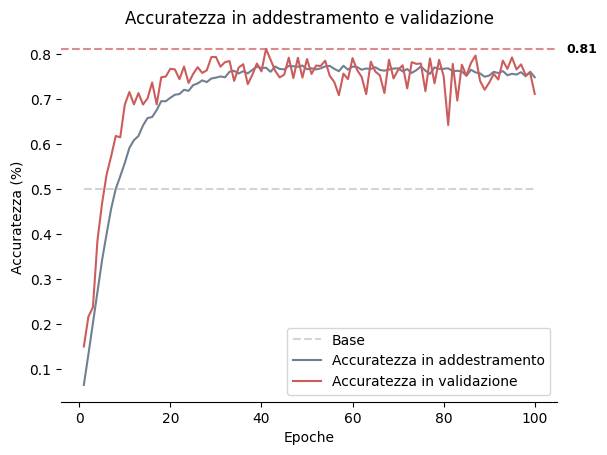

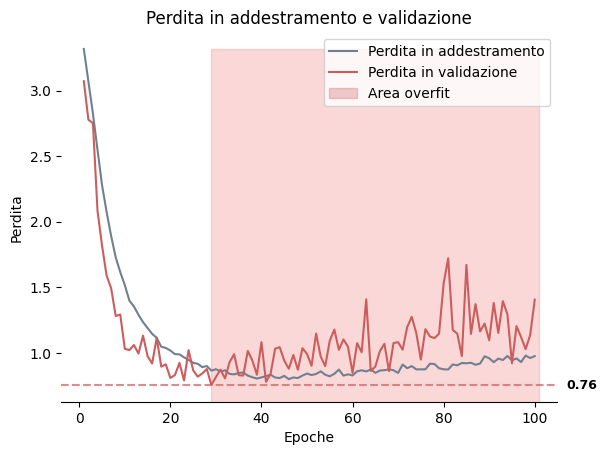

In [23]:
create_train_val_plot(improved_history.history)

Alleniamo il modello per 100 epoche (dobbiamo dargli più tempo per apprendere, 30 epoche non sarebbero bastate) e visualizziamo le **curve di addestramento** e **validazione**.

L'obbiettivo di ridurre **l'overfitting è stato comunque raggiunto**, dato che il modello ha iniziato ad andare in overfitting verso **l'epoca 30**.

In [24]:
improved_best_model = tf.keras.models.load_model("bestmodels/improved_basic_model.keras")
test_loss, test_acc = improved_best_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 7ms/step - loss: 0.8334 - accuracy: 0.7819
Accuratezza: 0.782


In questo caso non abbiamo ottenuto alcun tipo di miglioramento a livello di prestazioni, anzi è peggiorato!

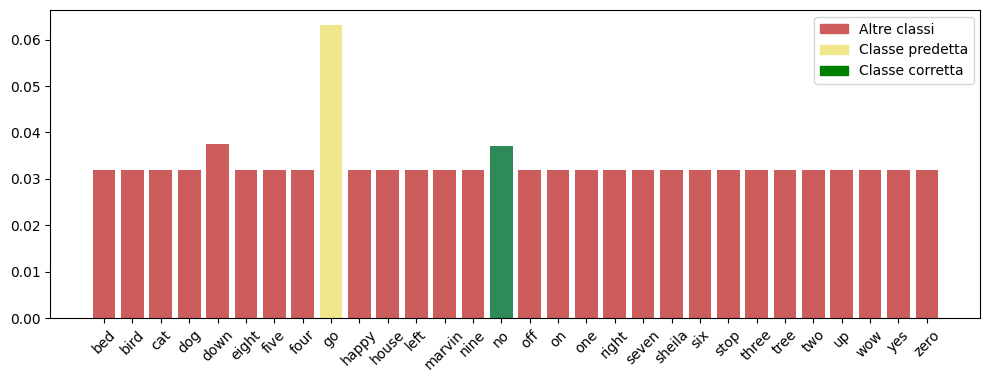

In [25]:
for audio, label in test_ds:
    create_distribution_plot(improved_best_model, audio, label)
    break

In questo caso il modello era molto più indeciso di prima. Il modello aveva intuito potesse essere un audio con **classe no** ma era convinto fosse invece la **classe go**.

## Miglioramenti all'architettura del modello

Durante il corso abbiamo visto anche delle best practice architetturali che possono aiutare a ottenere maggiori prestazioni col modello. Il nostro scopo è provare le tecniche viste e studiate durante il corso e capire come reagiscono al task.

Le tre tecniche che andremo ad applicare sono:
- blocchi residuali
- normalizzazione dei batch
- convoluzioni separabili

### Blocchi residuali
I blocchi residuali sono un'applicazione efficace quando riscontriamo il problema dei **gradienti che svaniscono**. Non sono una tecnica strettamente legata ai modelli convolutivi, ma sono una best practice generale che viene applicare nella maggior parte delle architetture. 

I **gradienti che vaniscono** sono causati dalle **catene di funzioni troppo lunghe**, che nel nostro caso non sono altro che **una sequenza di livelli convolutivi**. Per ogni livello convolutivo **una certa quantità di rumore** viene introdotta, finché essa non arriva a **sopraffare** le informazioni sul gradiente.

Se le informazioni sul gradiente sono sopraffatte la **backpropagation smette di funzionare**, e quindi il nostro **modello non impara**.

L'**idea basilare** dietro ai blocchi residuali è quella di **salvare l'informazione** contenuta nell'input precedente al livello convolutivo, e **sommarla all'output** dello stesso livello convolutivo.

Per applicare i blocchi residuali abbiamo implementato la funzione `residual_block(x, filters, pooling=False)` vista a lezione. La funzione è ovviamente adattata al modello da noi implementato, e utilizza le altre due best practice citate precedentemente.

In [26]:
def residual_block(x, filters, pooling=False):
    residual = x

    x = tf.keras.layers.SeparableConv2D(filters, 3, padding="same", use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)

    if pooling:
      x = tf.keras.layers.MaxPooling2D(pool_size=2, padding="same")(x)
      residual = tf.keras.layers.Conv2D(filters, 1, strides=2)(residual)
    elif filters != residual.shape[-1]:
      residual = tf.keras.layers.Conv2D(filters, 1)(residual)

    x = tf.keras.layers.add([x, residual])
    return x

### Normalizzazione dei batch e convoluzioni separabili
La **normalizzazione dei batch** è un concetto che abbiamo già affrontato nel notebook, infatti il suo scopo rimane quello di rendere i dati **più simili tra loro** centrandoli sullo zero, e ciò aiuta la **propagazione del gradiente**. Questa normalizzazione, a differenza della precedente, è in grado di normalizzare i dati in modo adattivo anche quando la media e la varianza cambiano durante l'addestramento.

Le **convoluzione separabili** invece sono un **sostituto** ai livelli convolutivi utilizzati fino ad adesso, e offrono un modello con maggiori prestazioni e meno parametri.

In [27]:
def bp_basic_model():
    # input e pre processamento
    inputs = tf.keras.Input(shape=(124, 129, 1))
    x = data_augmentation(inputs)
    x = tf.keras.layers.Resizing(120, 120)(x)

    x = residual_block(x, 32, pooling=True)
    x = residual_block(x, 64, pooling=True)
    x = residual_block(x, 128, pooling=True)
    x = residual_block(x, 256, pooling=True)
    x = residual_block(x, 256, pooling=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    # Livelli per la classificazione
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(30, activation="softmax")(x)

    # Modello
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [28]:
bp_basic_model = bp_basic_model()
bp_basic_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

bp_basic_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 124, 129, 1)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 129, 1)         0         ['input_5[0][0]']             
                                                                                                  
 resizing_4 (Resizing)       (None, 120, 120, 1)          0         ['sequential[3][0]']          
                                                                                                  
 separable_conv2d_1 (Separa  (None, 120, 120, 32)         41        ['resizing_4[0][0]']          
 bleConv2D)                                                                                 

Le best practice, insieme al `tf.keras.layers.GlobalAveragePooling2D()` applicato al posto del Flatten, hanno formato un modello con circa **160000 parametri addestrabili** (circa il 16% del modello precedente).

In [29]:
bp_basic_model_callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="bestmodels/bp_basic_model.keras", save_best_only=True, monitor="val_loss")]
bp_model_history = bp_basic_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=bp_basic_model_callbacks)

Epoch 1/100
243/243 [==============================] - 11s 24ms/step - loss: 3.4643 - accuracy: 0.0580 - val_loss: 3.4037 - val_accuracy: 0.0367
Epoch 2/100
243/243 [==============================] - 4s 18ms/step - loss: 3.1858 - accuracy: 0.1030 - val_loss: 3.0605 - val_accuracy: 0.1408
Epoch 3/100
243/243 [==============================] - 5s 18ms/step - loss: 3.0324 - accuracy: 0.1430 - val_loss: 2.8804 - val_accuracy: 0.1910
Epoch 4/100
243/243 [==============================] - 4s 18ms/step - loss: 2.8920 - accuracy: 0.1804 - val_loss: 2.6883 - val_accuracy: 0.2546
Epoch 5/100
243/243 [==============================] - 4s 18ms/step - loss: 2.7373 - accuracy: 0.2206 - val_loss: 2.6213 - val_accuracy: 0.2504
Epoch 6/100
243/243 [==============================] - 5s 19ms/step - loss: 2.5658 - accuracy: 0.2751 - val_loss: 2.2771 - val_accuracy: 0.3607
Epoch 7/100
243/243 [==============================] - 4s 18ms/step - loss: 2.4415 - accuracy: 0.3077 - val_loss: 2.1096 - val_accuracy

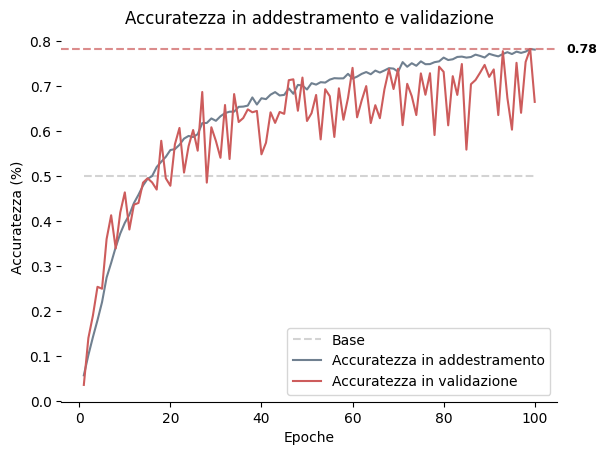

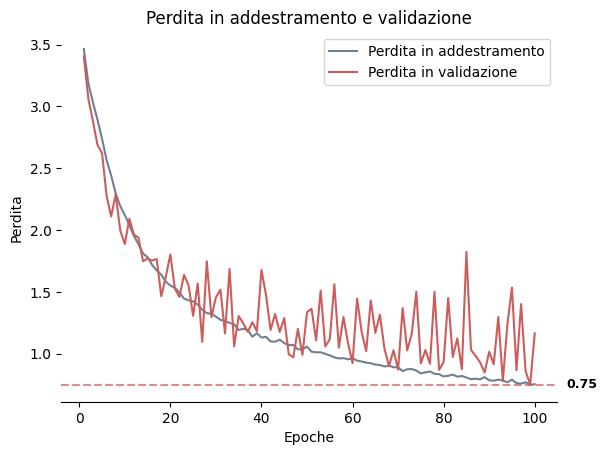

In [30]:
create_train_val_plot(bp_model_history.history, overfit=False)

Possiamo notare che il modello **NON ha raggiunto l'overfitting**, infatti probabilmente 100 epoche di addestramento erano troppo poche. La **loss della validazione** stava continuando a scendere, e allo stesso tempo **l'accuratezza della validazione era crescente**.

In [31]:
best_bp_basic_model = tf.keras.models.load_model("bestmodels/bp_basic_model.keras")
test_loss, test_acc = best_bp_basic_model.evaluate(test_ds)
print(f"Accuratezza: {test_acc:.3f}")

81/81 [==============================] - 1s 8ms/step - loss: 0.7508 - accuracy: 0.8024
Accuratezza: 0.802


Non abbiamo ottenuto miglioramenti a livello di prestazioni rispetto al primo modello presentato, però ci siamo avvicinati molto con il **16% dei parametri**

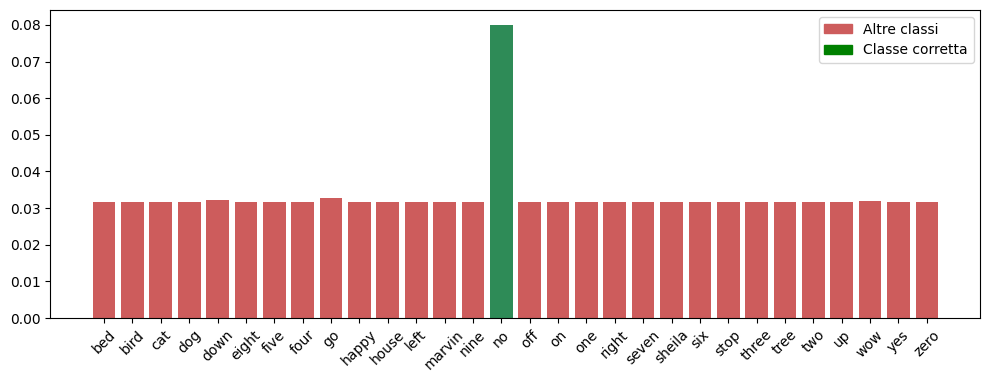

In [32]:
for audio, label in test_ds:
    create_distribution_plot(best_bp_basic_model, audio, label)
    break

La decisione del modello in questo caso è nuovamente molto chiara.